c:\Users\pedlo\AppData\Local\Programs\Python\Python313\Lib\site-packages\nbformat\__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


[encadenado] 02 ha ejecutado 01 y ya tiene `lap` y variables base.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2843 entries, 0 to 2842
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2843 non-null   object 
 1   Brand             2810 non-null   object 
 2   Screen_Size       2756 non-null   object 
 3   CPU_Model         2628 non-null   object 
 4   Ram               2711 non-null   object 
 5   Operating_System  2723 non-null   object 
 6   Rating            2283 non-null   float64
 7   Series            2501 non-null   object 
 8   Color             2109 non-null   object 
 9   Resolution        182 non-null    object 
 10  Weight            66 non-null     object 
 11  USB               35 non-null     float64
 12  Battery           7 non-null      object 
 13  Graphics          2063 non-null   object 
 14  Disk_size         2248 non-null   object 
 15  Card_desc         2635

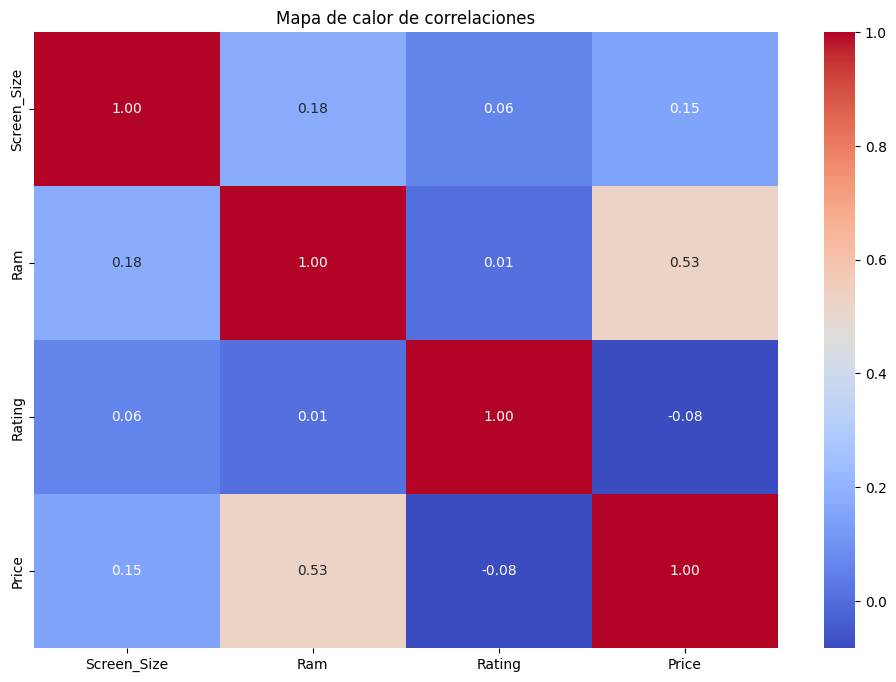

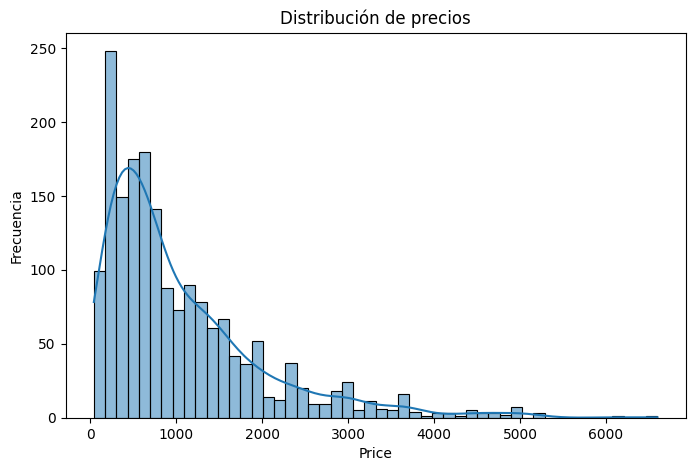

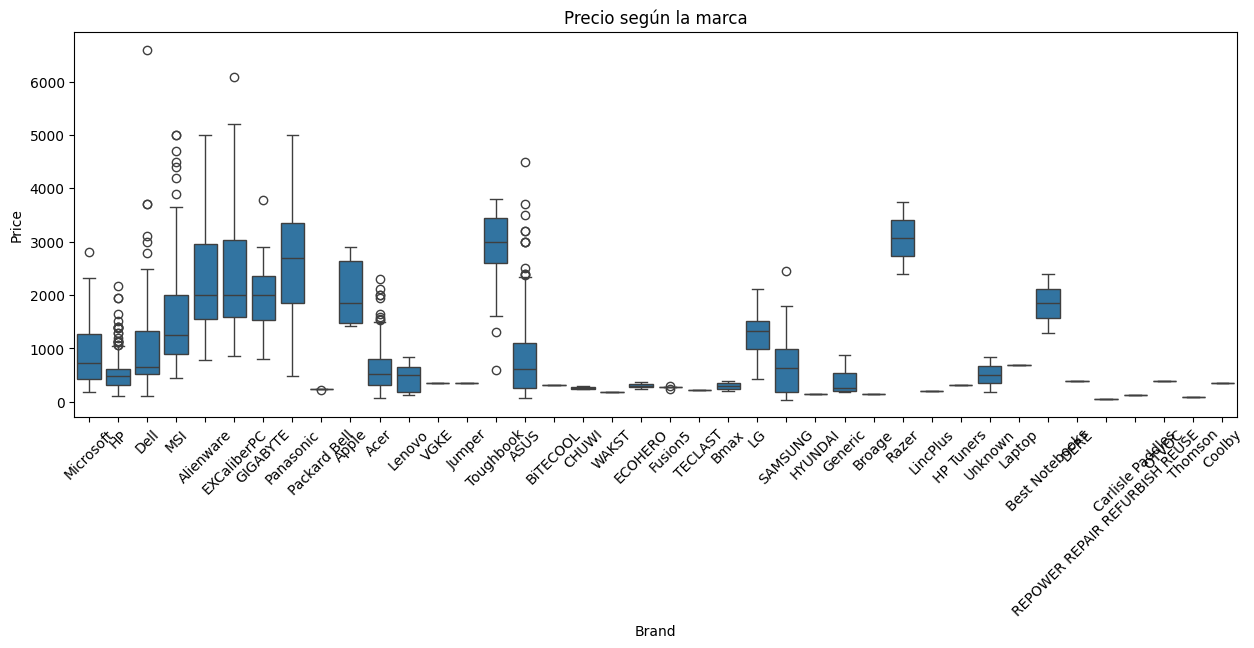

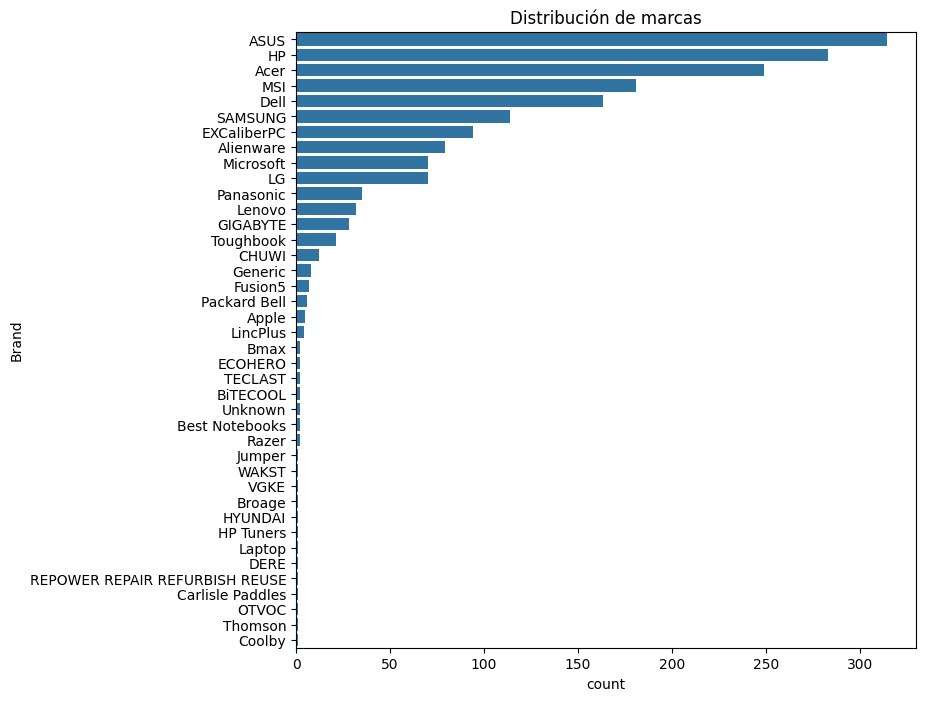

[OK] Procesado guardado en data/processed/dataset_procesado.csv
[encadenado] 03 ha ejecutado 02 (y 01), variables preparadas para modelado.


In [2]:
%run "02_LimpiezaEDA.ipynb"
print('[encadenado] 03 ha ejecutado 02 (y 01), variables preparadas para modelado.')


# 03 · Entrenamiento y Evaluación 

### COMO SE PUEDE APRECIAR EN EL JUPYTER ANTERIOR, QUEDAN NULOS EN RATING Y DISK SIZE. ES PORQUE VAMOS A APLICAR TRATAMIENTO ESTADÍSTICO QUE SE TIENE QUE EFECTUAR EN TRAIN, PARA QUE EL MODELO NO APRENDA DE ESOS DATOS

In [3]:
from sklearn.metrics import make_scorer, mean_squared_log_error
rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)


In [4]:
lap.columns

Index(['Title', 'Brand', 'Screen_Size', 'Ram', 'Rating', 'Price', 'CPU_Vendor',
       'CPU_Family', 'CPU_Class', 'CPU_Arch', 'OS_Family_Other',
       'OS_Family_Windows', 'OS_Family_macOS', 'Disk_GB'],
      dtype='object')

In [5]:
features = ['Brand', 'Screen_Size', 'Ram', 'Rating',
       'OS_Family_Other', 'OS_Family_Windows', 'OS_Family_macOS', 'Disk_GB',
       'CPU_Vendor', 'CPU_Family', 'CPU_Class', 'CPU_Arch']
target = 'Price'
df_model = lap[features + [target]].dropna(subset=[target]).copy()  


In [6]:
from sklearn.model_selection import train_test_split

X = df_model[features]
y = df_model[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(X_train.shape, X_test.shape)

(1441, 12) (361, 12)


In [7]:
# queda trabajar con los nulos. Vamos a aplicarles la
# moda para no perder tantas líneas


# Moda calculada SOLO con TRAIN
m = X_train['Disk_GB'].mode()
disk_mode = m.iloc[0] if not m.empty else X_train['Disk_GB'].median()

# Imputar usando esa moda en TRAIN y TEST
X_train['Disk_GB'] = X_train['Disk_GB'].fillna(disk_mode)
X_test['Disk_GB']  = X_test['Disk_GB'].fillna(disk_mode)

# Chequeo rápido
print('Moda (TRAIN) usada para Disk_GB:', disk_mode)
print('NaN restantes -> TRAIN:', X_train['Disk_GB'].isna().sum(),
      ' | TEST:', X_test['Disk_GB'].isna().sum())

Moda (TRAIN) usada para Disk_GB: 512.0
NaN restantes -> TRAIN: 0  | TEST: 0


In [8]:
# solo nos queda Rating. Este es un caso especial.
# vamos a tratarla como numérica, eveidentemente, pero teniendo cuidado
# con su casi 20% de nulos
# vamos a aplicar la MEDIANA (porque hay algún outlier) de BRAND

brand_med_train  = X_train.groupby('Brand')['Rating'].median()
global_med_train = X_train['Rating'].median()

# - En TRAIN: por mediana de cada Brand
X_train.loc[:, 'Rating'] = (
    X_train['Rating']
      .fillna(X_train['Brand'].map(brand_med_train))
      .fillna(global_med_train)
)

# - En TEST: usar las mismas medianas aprendidas en TRAIN; 

X_test.loc[:, 'Rating'] = (
    X_test['Rating']
      .fillna(X_test['Brand'].map(brand_med_train))
      .fillna(global_med_train)
)

# Chequeo
print('NaN Rating -> TRAIN:', X_train['Rating'].isna().sum(),
      '| TEST:', X_test['Rating'].isna().sum())
print('Mediana global (TRAIN):', global_med_train)

NaN Rating -> TRAIN: 0 | TEST: 0
Mediana global (TRAIN): 4.3


# YA HEMOS LIMPIADO TODOS LOS NULOS APLICANDO LA MODA Y MEDIANA DE TRAIN. 

AHORA, VAMOS CON EL ENTRENAMIENTO

In [9]:
# la idea es utilizar modelos de regresión (porque buscamos un precio)

# Utilizaremos como modelos lineales Ridge, Lasso y ElasctiNET. 

# como árboles Random y GradientBoost. 

# y como modelo NO supervisado, el Kmeans. 

In [10]:
X_test.dtypes

Brand                 object
Screen_Size          float64
Ram                    int64
Rating               float64
OS_Family_Other         bool
OS_Family_Windows       bool
OS_Family_macOS         bool
Disk_GB              float64
CPU_Vendor            object
CPU_Family            object
CPU_Class             object
CPU_Arch              object
dtype: object

In [11]:
## LIBRERÍAS  
import numpy as np
import pandas as pd
from pathlib import Path
import pickle, shutil, warnings, sys
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score

# Modelos supervisados
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# No supervisado
from sklearn.cluster import KMeans

In [12]:
# copiamos por si acaso
X_train = X_train.copy()
X_test  = X_test.copy()

# separamos numéricas y cat para sus diferentes usos

num_cols_use = X_train.select_dtypes(include=['number','bool']).columns.tolist()
cat_cols_use = X_train.select_dtypes(include=['object','category']).columns.tolist()

print('Numéricas:', num_cols_use)
print('Categóricas:', cat_cols_use)

Numéricas: ['Screen_Size', 'Ram', 'Rating', 'OS_Family_Other', 'OS_Family_Windows', 'OS_Family_macOS', 'Disk_GB']
Categóricas: ['Brand', 'CPU_Vendor', 'CPU_Family', 'CPU_Class', 'CPU_Arch']


In [13]:
# en las cat de CPU, faltaba hacer en One hot 

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [14]:
# Preprocesamiento

def build_preprocessor(scale_numeric=False):
    num_steps = [('imp', SimpleImputer(strategy='median'))]
    if scale_numeric:
        num_steps.append(('sc', StandardScaler()))
    num_pipe = Pipeline(num_steps)

    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('ohe', ohe)
    ])

    transformers = []
    if num_cols_use:
        transformers.append(('num', num_pipe, num_cols_use))
    if cat_cols_use:
        transformers.append(('cat', cat_pipe, cat_cols_use))

    return ColumnTransformer(transformers, remainder='drop')

In [15]:
## función para las métricas de después

def eval_reg(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)            
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [ ]:
## vamos allá. Hiperparámetros para el pipeline
from sklearn.compose import TransformedTargetRegressor
import numpy as np

model_specs = [
    {
        'name': 'Ridge',
        'estimator': Ridge(),
        'pre_scale': True,
        'param_grid': {'mdl__alpha': np.logspace(-3, 3, 7)}
    },
    {
        'name': 'Lasso',
        'estimator': Lasso(max_iter=10000),
        'pre_scale': True,
        'param_grid': {'mdl__alpha': np.logspace(-4, 1, 6)}
    },
    {
        'name': 'ElasticNet',
        'estimator': ElasticNet(max_iter=10000),
        'pre_scale': True,
        'param_grid': {
            'mdl__alpha':    np.logspace(-4, 1, 6),
            'mdl__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    },
    {
        'name': 'RandomForest',
        'estimator': RandomForestRegressor(random_state=42, n_jobs=-1),
        'pre_scale': False,
        'param_grid': {
            'mdl__n_estimators': [200, 400, 800],
            'mdl__max_depth': [None, 10, 20, 40],
            'mdl__min_samples_leaf': [1, 2, 5],
            'mdl__max_features': ['sqrt', None]
        }
    },
    {
        'name': 'GradientBoosting',
        'estimator': GradientBoostingRegressor(random_state=42),
        'pre_scale': False,
        'param_grid': {
            'mdl__n_estimators': [200, 400],
            'mdl__learning_rate': [0.03, 0.06, 0.1],
            'mdl__max_depth': [2, 3, 4],
            'mdl__min_samples_leaf': [1, 2, 5]
        }
    },
    {
        'name': 'GradientBoosting_LOG',
        'estimator': TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(random_state=42),
            func=np.log1p,
            inverse_func=np.expm1
        ),
        'pre_scale': False,
        'param_grid': {
            'mdl__regressor__n_estimators':    [200, 400],
            'mdl__regressor__learning_rate':   [0.03, 0.06, 0.1],
            'mdl__regressor__max_depth':       [2, 3, 4],
            'mdl__regressor__min_samples_leaf':[1, 2, 5],
        }
    },
    # <<< GradientBoosting con pérdida Huber + target en log >>>
    {
        'name': 'GradientBoosting_HUBER_LOG',  
        'estimator': TransformedTargetRegressor(
            regressor=GradientBoostingRegressor(random_state=42, loss='huber'),
            func=np.log1p,
            inverse_func=np.expm1
        ),
        'pre_scale': False,
        'param_grid': {
            'mdl__regressor__n_estimators':    [300, 600],
            'mdl__regressor__learning_rate':   [0.03, 0.06],
            'mdl__regressor__max_depth':       [2, 3],
            'mdl__regressor__min_samples_leaf':[2, 5],
            'mdl__regressor__alpha':           [0.85, 0.9, 0.95]  # umbral Huber
        }
    },
]


In [17]:
assert (y_train >= 0).all() and (y_test >= 0).all(), "Price debe ser >= 0 para usar log1p."


In [18]:
from sklearn.metrics import make_scorer, mean_squared_log_error
rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

# cross validation 
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
best_pipelines = {}

for spec in model_specs:
    name = spec['name']
    print(f'\n>>> Entrenando {name}...')

    pre = build_preprocessor(scale_numeric=spec['pre_scale'])
    pipe = Pipeline([('pre', pre), ('mdl', spec['estimator'])])

    # Usa RMSLE para los modelos en log (_LOG), MSE para el resto
    scorer = rmsle_scorer if name.endswith('_LOG') else 'neg_mean_squared_error'

    grid = GridSearchCV(
        pipe,
        param_grid=spec['param_grid'],
        cv=cv,
        n_jobs=-1,
        scoring=scorer,
        verbose=0
    )

    # Pesar SOLO los modelos _LOG para aproximar objetivo relativo
    fit_params = {}
    if name.endswith('_LOG'):
        fit_params = {'mdl__sample_weight': 1.0 / (y_train.values + 1.0)}

    grid.fit(X_train, y_train, **fit_params)

    best_pipelines[name] = grid.best_estimator_

    # Test
    y_pred = grid.best_estimator_.predict(X_test)
    metrics = eval_reg(y_test, y_pred)

    
    cv_best = np.sqrt(-grid.best_score_)

    result = {
        'model': name,
        'best_params': grid.best_params_,
        'cv_best_rmse': cv_best,    # para _LOG realmente RMSLE
        'RMSE_test': metrics['RMSE'],
        'MAE_test':  metrics['MAE'],
        'R2_test':   metrics['R2'],
    }
    results.append(result)
    print(result)

results_df = pd.DataFrame(results).sort_values('RMSE_test')



>>> Entrenando Ridge...
{'model': 'Ridge', 'best_params': {'mdl__alpha': np.float64(0.001)}, 'cv_best_rmse': np.float64(5176.7715964727595), 'RMSE_test': np.float64(499.168850085756), 'MAE_test': 310.870741875539, 'R2_test': 0.7244986823087258}

>>> Entrenando Lasso...
{'model': 'Lasso', 'best_params': {'mdl__alpha': np.float64(0.0001)}, 'cv_best_rmse': np.float64(5175.082356192642), 'RMSE_test': np.float64(499.2992358495409), 'MAE_test': 311.36490948055865, 'R2_test': 0.7243547384662004}

>>> Entrenando ElasticNet...
{'model': 'ElasticNet', 'best_params': {'mdl__alpha': np.float64(10.0), 'mdl__l1_ratio': 0.1}, 'cv_best_rmse': np.float64(2638.4154348451684), 'RMSE_test': np.float64(913.9221545362221), 'MAE_test': 662.9432740320135, 'R2_test': 0.07647822690039141}

>>> Entrenando RandomForest...
{'model': 'RandomForest', 'best_params': {'mdl__max_depth': 20, 'mdl__max_features': 'sqrt', 'mdl__min_samples_leaf': 1, 'mdl__n_estimators': 800}, 'cv_best_rmse': np.float64(433.3162734957799)

In [19]:
# ahora vamos con el Kmean (no supervisado)

pre_unsup = build_preprocessor(scale_numeric=True)
X_train_tr = pre_unsup.fit_transform(X_train)  # fit SOLO con TRAIN

sil_scores = {}
for k in [3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_tr)
    sil = silhouette_score(X_train_tr, labels)
    sil_scores[k] = sil
    print(f'KMeans k={k} -> silhouette={sil:.3f}')

best_k = max(sil_scores, key=sil_scores.get)
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_train_tr)

KMeans k=3 -> silhouette=0.390
KMeans k=4 -> silhouette=0.196
KMeans k=5 -> silhouette=0.202
KMeans k=6 -> silhouette=0.269


In [20]:
# guardado de resultados y mejores modelos

Path('models').mkdir(parents=True, exist_ok=True)
Path('docs').mkdir(parents=True, exist_ok=True)

# Supervisados
for name, pipe in best_pipelines.items():
    with open(f'models/trained_model_{name}.pkl', 'wb') as f:
        pickle.dump(pipe, f)

# Elige final por menor RMSE_test
best_row = results_df.iloc[0]
final_name = best_row['model']
shutil.copyfile(f'models/trained_model_{final_name}.pkl', 'models/final_model.pkl')

# No supervisado
with open('models/pre_unsup.pkl', 'wb') as f:
    pickle.dump(pre_unsup, f)
with open('models/kmeans.pkl', 'wb') as f:
    pickle.dump(kmeans_best, f)

In [21]:
# Resultados
results_df.to_csv('docs/model_results.csv', index=False)

print(f'\nModelo final: {final_name}')
print('Resultados guardados en models/ y docs/model_results.csv')


Modelo final: RandomForest
Resultados guardados en models/ y docs/model_results.csv


In [22]:
##revisamos qué ha dado cada modelo

cols = ['model','cv_best_rmse','RMSE_test','MAE_test','R2_test']
print(results_df[cols].sort_values('RMSE_test'))


                        model  cv_best_rmse   RMSE_test    MAE_test   R2_test
3                RandomForest    433.316273  478.789521  264.607453  0.746535
4            GradientBoosting    440.890616  491.279719  289.573490  0.733138
0                       Ridge   5176.771596  499.168850  310.870742  0.724499
1                       Lasso   5175.082356  499.299236  311.364909  0.724355
6  GradientBoosting_HUBER_LOG      0.341581  548.718949  296.622556  0.667089
5        GradientBoosting_LOG      0.325073  550.074337  285.649272  0.665442
2                  ElasticNet   2638.415435  913.922155  662.943274  0.076478


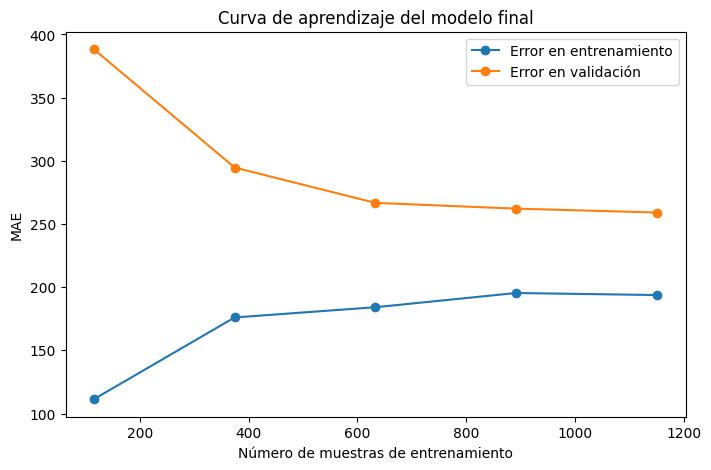

In [23]:
# gáfica para ver cómo evolucionan los errores del modelo con datos nuevos 
modelo_final = grid.best_estimator_

from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    modelo_final, X_train, y_train, cv=5, scoring="neg_mean_absolute_error"
)
train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label="Error en entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', label="Error en validación")
plt.xlabel("Número de muestras de entrenamiento")
plt.ylabel("MAE")
plt.title("Curva de aprendizaje del modelo final")
plt.legend()
plt.show()


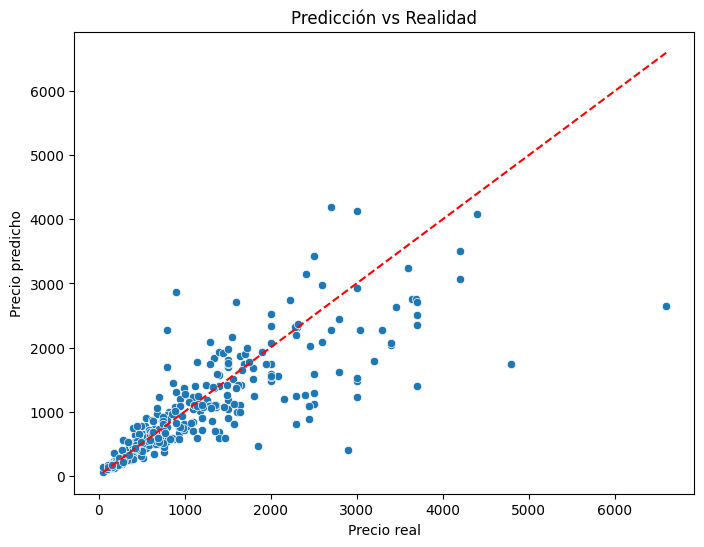

In [24]:
# predicciones vs realidad

y_pred = modelo_final.predict(X_test)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Predicción vs Realidad")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


In [25]:
# Guardar train/test si existen en variables X_train/X_test/y_train/y_test
from pathlib import Path
import pandas as pd
try:
    root = Path.cwd().parent
    train_dir = root / 'data' / 'train'
    test_dir  = root / 'data' / 'test'
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    if all(k in globals() for k in ['X_train','X_test','y_train','y_test']):
        df_tr = X_train.copy(); df_tr['Price'] = y_train
        df_te = X_test.copy();  df_te['Price'] = y_test
        df_tr.to_csv(train_dir/'train.csv', index=False)
        df_te.to_csv(test_dir/'test.csv', index=False)
        print('[OK] Train/Test guardados en data/train y data/test')
    else:
        print('[Aviso] No encuentro variables X_train/X_test/y_train/y_test; omito guardado automático.')
except Exception as e:
    print('[Aviso] No se pudo guardar train/test:', e)


[OK] Train/Test guardados en data/train y data/test


In [ ]:
# === AUTODETECCIÓN Y GUARDADO DEL MODELO FINAL ===
from pathlib import Path
import joblib

# modelo final automáticamente
modelo_final = None
candidatos = {}

# Detectar objetos "parecen modelo entrenado"
for _name, _obj in list(globals().items()):
    if _name.startswith("_"): 
        continue
    # Saltar módulos y cosas comunes
    if _name in {"pd","np","plt","sns","Path","joblib","os"}:
        continue
    try:
        tiene_predict = hasattr(_obj, "predict")
        # Señales de que está "fitted"
        fitted = any(hasattr(_obj, a) for a in ("n_features_in_", "classes_", "feature_importances_", "coef_", "best_estimator_"))
        if tiene_predict and fitted:
            candidatos[_name] = _obj
    except Exception:
        pass

# Con GridSearchCV, elegimos el de mejor score
try:
    from sklearn.model_selection import GridSearchCV
    grids = {n:o for n,o in candidatos.items() if isinstance(o, GridSearchCV)}
    if grids:
        mejor = max(grids, key=lambda n: getattr(grids[n], "best_score_", float("-inf")))
        print(f"[auto] Tomo el mejor GridSearchCV: {mejor} (best_score_={getattr(grids[mejor], 'best_score_', None)})")
        modelo_final = grids[mejor].best_estimator_
except Exception:
    pass

# Si no había GridSearchCV, intentamos heurística por nombre
if modelo_final is None and candidatos:
    prioridad = ["modelo_final","mejor_modelo","best_model","final_model","grid","gs","grid_search","pipe","pipeline","clf","model"]
    for p in prioridad:
        if p in candidatos:
            print(f"[auto] Tomo el candidato por nombre: {p}")
            modelo_final = candidatos[p]
            break

# Si aún no, y hay un único candidato… nos quedamos con él
if modelo_final is None and len(candidatos) == 1:
    k = next(iter(candidatos))
    print(f"[auto] Solo hay un candidato visible: {k}")
    modelo_final = candidatos[k]

# 2) Guardar si lo encontramos
models_dir = Path.cwd().parent / "models"
models_dir.mkdir(parents=True, exist_ok=True)

if modelo_final is not None:
    joblib.dump(modelo_final, models_dir / "final_model.pkl")
    print("[OK] Modelo final guardado en models/final_model.pkl")
    try:
        # guardado con nombre de clase a modo informativo
        nombre_clase = modelo_final.__class__.__name__
        (models_dir / "FINAL_MODEL_INFO.txt").write_text(f"Modelo final: {nombre_clase}\n", encoding="utf-8")
    except Exception:
        pass
else:
    print("[AVISO] No pude identificar automáticamente el modelo final.")
    print("Candidatos detectados:", list(candidatos.keys()))
    print("Solución rápida: asigna, por ejemplo ->  modelo_final = grid.best_estimator_  (o al nombre que uses) y vuelve a ejecutar esta celda.")


[auto] Tomo el mejor GridSearchCV: grid (best_score_=-0.1166778758438896)
[OK] Modelo final guardado en models/final_model.pkl


In [27]:
## para guardar todos los modelos entrenados y de prueba

from pathlib import Path
import joblib

models_dir = Path.cwd().parent / "models"
models_dir.mkdir(parents=True, exist_ok=True)

for name, obj in globals().items():
    try:
        if hasattr(obj, "predict"):
            joblib.dump(obj, models_dir / f"{name}.pkl")
            print(f"[OK] Guardado {name}.pkl")
    except Exception:
        pass


RuntimeError: dictionary changed size during iteration

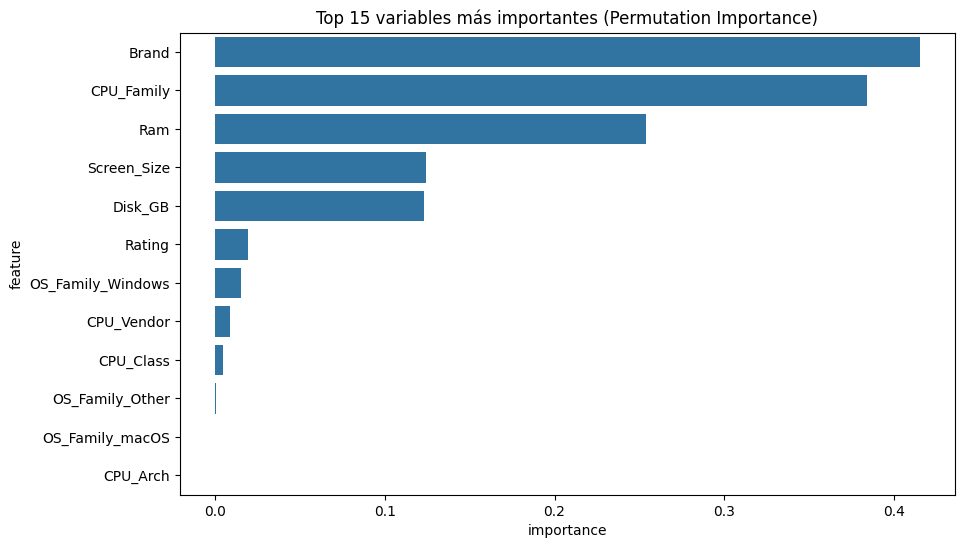

In [28]:
from sklearn.inspection import permutation_importance

result = permutation_importance(modelo_final, X_test, y_test, n_repeats=10, random_state=42)

imp_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=imp_df)
plt.title("Top 15 variables más importantes (Permutation Importance)")
plt.show()
